# CS 431 Lab 3
## Schedule Solver
### Winter 2017

In [250]:
dataFiles = {"Classes":        "classes.txt",
             "Rooms":          "rooms.txt",
             "Times":          "times.txt",
             "TimeConflicts":  "time_conflicts.txt",
             "CourseConflicts":"course_conflicts.txt",
             "Preferences":    "preferences.txt"}

In [274]:
from icalendar import Calendar, Event
from datetime import datetime
import pickle

class Scheduler:
    """A class to handle all the input data, and common functions, for
       the schedule optimizer problem
    """
    # Instance data summarized here
    # self.files
    # self.instructorByIndex
    # self.instructorIndexByName
    # self.classInfoByIndex
    # self.classIndexByName
    # self.roomByIndex
    # self.roomIndexByName
    # self.timeSlotByIndex
    # self.timeConflictByIndex
    # self.courseConflictsByIndex
    # self.instructorPrefByIndex
    
    def __init__(self, fileDict):
        """Constructor.  Get all the input files read and basic data
           structures built
        """
        self.files = fileDict
        self.loadInstructorsAndClasses()
        self.loadRooms()
        self.loadTimeSlots()
        self.loadTimeConflicts()
        self.loadCourseConflicts()
        self.loadPreferences()
            
    def loadInstructorsAndClasses(self):
        """Read the classes file and extract instructors and classes
           Gives defines an index for each class and each instructor, i.e.
           Jie Liu has index 4, CS 365 has index 2
        """
        ic = Scheduler.loadFile(self.files["Classes"], True, lambda a,b : (a,b))
        # eliminate duplicates and order instructors alphabetically, 
        instructors = sorted(set([i for (i,c) in ic]))
        self.instructorByIndex = {}
        self.instructorIndexByName = {}
        for i in range(len(instructors)):
            self.instructorByIndex[i] = instructors[i]
            self.instructorIndexByName[instructors[i]] = i
        self.classInfoByIndex = {}
        self.classIndexByName = {}
        classIndex = 0
        for (inst,cls) in ic:
            self.classInfoByIndex[classIndex] = [cls,inst,self.instructorIndexByName[inst]]
            self.classIndexByName[cls] = classIndex
            classIndex = classIndex + 1
    
    def loadRooms(self):
        """Read the rooms file and assign indices to rooms"""
        rms = Scheduler.loadFile(self.files["Rooms"], False )
        self.roomByIndex = {}
        self.roomIndexByName = {}
        for i in range(len(rms)):
            self.roomByIndex[i] = rms[i][0]
            self.roomIndexByName[rms[i][0]] = i
    
    def loadTimeSlots(self):
        """Read the times file and assign indices to time slots"""
        ts = Scheduler.loadFile(self.files["Times"], True, lambda a,b,c,d : (int(a),b,int(c),d))
        self.timeSlotByIndex = {}
        for (ti,tstr,thrs,tdays) in ts:
            self.timeSlotByIndex[ti] = [tstr,thrs,tdays]
    
    def loadTimeConflicts(self):
        """Read the time conflicts file and build a lookup table to see if two time slots conflict"""
        tc = Scheduler.loadFile(self.files["TimeConflicts"], True, lambda a,b : (int(a),int(b)))
        self.timeConflictByIndex = {}
        # add all time slots first
        for i in self.timeSlotByIndex:
            self.timeConflictByIndex[i] = [i]        # time slots conflict with themselves
        for (t1,t2) in tc:
            if t1 in self.timeConflictByIndex:
                self.timeConflictByIndex[t1].append(t2)
            else:
                self.timeConflictByIndex[t1] = [t2]  # unnecessary now that dict is prepopulated
            if t2 in self.timeConflictByIndex:
                self.timeConflictByIndex[t2].append(t1)
            else:
                self.timeConflictByIndex[t2] = [t1]  # unnecessary now
    
    def loadCourseConflicts(self):
        """Read the course conflicts file and build a table of conflicts"""
        cc = Scheduler.loadFile(self.files["CourseConflicts"], False )
        cc = [[self.classIndexByName[cn] for cn in c] for c in cc]
        cc = [[(a,b) for a in c for b in c if a != b] for c in cc]
        cc = [pair for entry in cc for pair in entry]  # flatten list
        self.courseConflictsByIndex = {}
        for key,value in self.classInfoByIndex.items():
            self.courseConflictsByIndex[key] = []   # start with no conflicts for all
        # then add them in
        for (a,b) in cc:
            self.courseConflictsByIndex[a].append(b)
            
    def loadPreferences(self):
        """Read the preferences file"""
        prefs = Scheduler.loadFile(self.files["Preferences"], True, lambda a,b : (a,int(b)) )
        self.instructorPrefByIndex = {}
        for (instructorName,pref) in prefs:
            instructorID = self.instructorIndexByName[instructorName]
            self.instructorPrefByIndex[instructorID] = pref
    
    def loadFile(path, applyFunction = True, fn = lambda x : x, splitOn = '|'):
        """Helper (class) method to read contents of file into a list, optionally
           applying a function to each line
        """
        output = []
        with open(path, encoding='utf-8') as f:
            for line in f:
                #output.append(list(map(fn,line.rstrip().split(splitOn))))
                if applyFunction:
                    output.append(fn(*(line.rstrip().split(splitOn))))
                else:
                    output.append(line.rstrip().split(splitOn))
                # map returns an iterator, use list() to force it into a list object
        return output
    
    # Helper methods
    def toStringByClassTimeRoom(self,classID,timeID,roomID):
        data = {"class"      : self.classInfoByIndex[classID][0],
                "instructor" : self.classInfoByIndex[classID][1],
                "time"       : self.timeSlotByIndex[timeID][0],
                "days"       : self.timeSlotByIndex[timeID][2],
                "room"       : self.roomByIndex[roomID]}
        return "{class}\t{time}\t{days}\t{instructor}\t{room}".format(**data)
            # The weird looking **data is Python's way of unpacking a dictionary
            # To unpack a list or tuple, it would be *data
    
    def toIcalEventByClassTimeRoom(self,classID,timeID,roomID):
        className  = self.classInfoByIndex[classID][0]
        instructor = self.classInfoByIndex[classID][1]
        time       = self.timeSlotByIndex[timeID][0]
        days       = self.timeSlotByIndex[timeID][2]
        room       = self.roomByIndex[roomID]
        
        # parameters for generating an iCalendar schedule
        # TODO: make these parameters
        SYEAR  = 2017   # events will start on this week, give the day as Monday
        SMONTH = 2
        SDAY   = 13
        
        # Assume time is in HHMM-HHMM format always
        (startTime,endTime) =time.split('-')
        startTimeHH = int(startTime[0:2])    # int('09') returns 9
        startTimeMM = int(startTime[2:])
        endTimeHH   = int(endTime[0:2])
        endTimeMM   = int(endTime[2:])
        
        dtstamp = datetime.now()
        event = Event()
        event.add('summary','{} {}'.format(className,instructor))
        event.add('dtstamp', dtstamp)
        if days == 'MTWR':
            # SDAY is monday so no change
            event.add('rrule', {'freq':'daily', 'interval':1, 'count':4})
        elif days == 'MW':
            # SDAY also starts on monday
            event.add('rrule', {'freq':'daily', 'interval':2, 'count':2})
        elif days == 'TR':
            # first class is Tuesday, one after Monday
            SDAY = SDAY + 1
            event.add('rrule', {'freq':'daily', 'interval':2, 'count':2})
            
        event.add('dtstart',datetime(SYEAR,SMONTH,SDAY,startTimeHH,startTimeMM))
        event.add('dtend',  datetime(SYEAR,SMONTH,SDAY,endTimeHH,endTimeMM))
        
        return event
        
    def printSchedule(self,sked):
        # Print the entire schedule
        for i in range(sked.shape[0]):
            print(self.toStringByClassTimeRoom(sked[i,0],sked[i,1],sked[i,2]))
    
    def findCourseInSchedule(self, sked, courseID):
        """Returns the index in the schedule of the course with courseID."""
        for i in range(sked.shape[0]):
            if sked[i,0] == courseID:
                return sked[i,1]
    
    def countGapsInTimes(self,timeIDs):
        """timeIDs = list of time IDs
        Finds the number of hours (or time slots?) between courses occupying these
        time slots (only for the same days).  Returns this.
        Possible change: allow 1 hour gaps and count only those greater than 1 hour"""
        # draw a grid of the courses to see the pattern:
        # MTWR in order     0 - 8
        # MW   odd numbers  9-15
        # TR   even numbers 10-16
        mtwr = sorted([t for t in timeIDs if t < 9], reverse=True)
        mw   = sorted([t for t in timeIDs if t > 8 and t < 17 and t%2 == 1], reverse=True)
        tr   = sorted([t for t in timeIDs if t > 8 and t < 17 and t%2 == 0], reverse=True)
        #print('mtwr: {}, mw: {}, tr: {}'.format(mtwr,mw,tr), end=' ')
        # add up all the differences in adjacent times, adjusting for 1 vs. 2 hour formats
        n = 0
        for i in range(1,len(mtwr)):
            n += mtwr[i-1] - mtwr[i] - 1
        for i in range(1,len(mw)):
            n += mw[i-1] - mw[i] - 2
        for i in range(1,len(tr)):
            n += tr[i-1] - tr[i] - 2
        
        return n
    
    def numberOfInstructors(self):
        instrsIDs = self.instructorByIndex.keys()
        ni = len(instrsIDs)
        assert ni == max(instrsIDs) - min(instrsIDs) + 1
        return ni
    
    def numberOfCourses(self):
        courseIDs = self.classInfoByIndex.keys()
        nc = len(courseIDs)
        assert nc == max(courseIDs) - min(courseIDs) + 1
        return nc
    
    def numberOfTimeSlots(self):
        timeIDs = self.timeSlotByIndex.keys()
        nt = len(timeIDs)
        assert nt == max(timeIDs) - min(timeIDs) + 1
        return nt
    
    def numberOfRooms(self):
        roomIDs = self.roomByIndex.keys()
        nr = len(roomIDs)
        assert nr == max(roomIDs) - min(roomIDs) + 1
        return nr
    
    def coursesConflict(self,c1,c2):
        """Do courses with ids of c1 and c2 conflict with each other?"""
        if c1 not in self.classInfoByIndex or c2 not in self.classInfoByIndex:
            print("Course index out of range")
            raise KeyError()
        return c2 in self.courseConflictsByIndex[c1]
    
    def timesConflict(self,t1,t2):
        """Do time slots with ids of t1 and t2 conflict with each otehr?"""
        if t1 not in self.timeSlotByIndex or t2 not in self.timeSlotByIndex:
            print("Time slot index out of range: {} or {} not in 0-{}".format(t1,t2,max(self.timeSlotByIndex.keys())))
            raise KeyError()
        return t2 in self.timeConflictByIndex[t1]

    def displayCal(cal):
        """Helper function to view calendar output with correct newlines.  Not needed to write to a file"""
        print(cal.to_ical().replace(b'\r\n',b'\n').strip().decode('utf-8'))

    def createCalendarFiles(self,sked):
        """sked = a schedule (numpy array Numclasses x 3)
        Will write one file (in the current directory) for each
        room.  File name uses the room name.
        """
        # Create iCalendar files from the schedule, one per room
        cals = {}
        for (roomID,roomStr) in self.roomByIndex.items():
            cals[roomStr] = Calendar()
            cals[roomStr].add('prodid','-//WOUScheduler//CS 431//EN')
            cals[roomStr].add('version','2.0')

        #sked = curr[1]
        for i in range(sked.shape[0]):
            event = self.toIcalEventByClassTimeRoom(sked[i,0],sked[i,1],sked[i,2])
            roomID = sked[i,2]
            roomStr = self.roomByIndex[roomID]
            cals[roomStr].add_component(event)

        for (roomStr,cal) in cals.items():
            fname = roomStr.replace(" ","_")+".ics"
            with open(fname,'wb') as fout:
                fout.write(cal.to_ical())
    
    def saveSchedule(self,sked,trSlotsRemaining,filename):
        """Serialize a schedule to a file.  Filename suffix for pickled data is typically .pickle
        We use an instance method here to get the data file names."""
        # Store the schedule, times remaining and the data files used
        data = {"sked":sked, "trSlotsRemaining":trSlotsRemaining, "dataFiles":self.files}
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    
    def loadSchedule(filename):
        """Load a schedule that was previously saved with saveSchedule."""
        with open(filename, 'rb') as f:
            # The protocol version used is detected automatically, so we do not
            # have to specify it.
            data = pickle.load(f)
        s = Scheduler(data["dataFiles"])
        sked = data["sked"]
        trSlotsRemaining = data["trSlotsRemaining"]
        return (s,sked,trSlotsRemaining)

In [275]:
# Try it out
s = Scheduler(dataFiles)

### Instructors

In [28]:
s.instructorByIndex

{0: 'Allison Omlid',
 1: 'Christopher Brooks',
 2: 'David Olson',
 3: 'Donald Kraus',
 4: 'Jie Liu',
 5: 'John Marsaglia',
 6: 'Mitchel Fry',
 7: 'Rebecca Morgan',
 8: 'Scot Morse',
 9: 'Theodore Beers',
 10: 'Yanwei Wu'}

### Courses
`course index : [Course name, instructor name, instructor index]`

In [29]:
s.classInfoByIndex

{0: ['CS 653', 'Jie Liu', 4],
 1: ['CS 361', 'Jie Liu', 4],
 2: ['CS 365', 'Jie Liu', 4],
 3: ['CS 461', 'Scot Morse', 8],
 4: ['CS 431', 'Scot Morse', 8],
 5: ['CS 260', 'Mitchel Fry', 6],
 6: ['CS 271a', 'Mitchel Fry', 6],
 7: ['CS 271b', 'Mitchel Fry', 6],
 8: ['IS 642', 'David Olson', 2],
 9: ['CS 125a', 'David Olson', 2],
 10: ['CS 160', 'Rebecca Morgan', 7],
 11: ['CS 161a', 'Rebecca Morgan', 7],
 12: ['CS 161b', 'Rebecca Morgan', 7],
 13: ['CS 432', 'John Marsaglia', 5],
 14: ['CS 125b', 'John Marsaglia', 5],
 15: ['IS 625', 'John Marsaglia', 5],
 16: ['IS 470', 'Christopher Brooks', 1],
 17: ['IS 350', 'Christopher Brooks', 1],
 18: ['IS 340', 'Christopher Brooks', 1],
 19: ['IS 270', 'Theodore Beers', 9],
 20: ['IS 440', 'Theodore Beers', 9],
 21: ['CS 134', 'Theodore Beers', 9],
 22: ['CS 123a', 'Theodore Beers', 9],
 23: ['CS 123b', 'Theodore Beers', 9],
 24: ['CS 125c', 'Allison Omlid', 0],
 25: ['CS 121a', 'Allison Omlid', 0],
 26: ['CS 126a', 'Yanwei Wu', 10],
 27: ['CS 1

### Rooms

In [30]:
s.roomByIndex

{0: 'ITC 301', 1: 'ITC 303', 2: 'ITC 311', 3: 'MC 101'}

### Time slots
`index : [time slot, days per week, days meeting]`

In [31]:
s.timeSlotByIndex

{0: ['0800-0850', 4, 'MTWR'],
 1: ['0900-0950', 4, 'MTWR'],
 2: ['1000-1050', 4, 'MTWR'],
 3: ['1100-1150', 4, 'MTWR'],
 4: ['1200-1250', 4, 'MTWR'],
 5: ['1300-1350', 4, 'MTWR'],
 6: ['1400-1450', 4, 'MTWR'],
 7: ['1500-1550', 4, 'MTWR'],
 8: ['1600-1650', 4, 'MTWR'],
 9: ['0800-0950', 2, 'MW'],
 10: ['0800-0950', 2, 'TR'],
 11: ['1000-1150', 2, 'MW'],
 12: ['1000-1150', 2, 'TR'],
 13: ['1200-1350', 2, 'MW'],
 14: ['1200-1350', 2, 'TR'],
 15: ['1400-1550', 2, 'MW'],
 16: ['1400-1550', 2, 'TR']}

### Time Slot Conflicts
e.g. time slot 4 conflicts with time slots 13 and 14
and 14 conflicts with 4 and 5, and all time slots conflict with themselves.

In [32]:
s.timeConflictByIndex

{0: [0, 9, 10],
 1: [1, 9, 10],
 2: [2, 11, 12],
 3: [3, 11, 12],
 4: [4, 13, 14],
 5: [5, 13, 14],
 6: [6, 15, 16],
 7: [7, 15, 16],
 8: [8],
 9: [9, 0, 1],
 10: [10, 0, 1],
 11: [11, 2, 3],
 12: [12, 2, 3],
 13: [13, 4, 5],
 14: [14, 4, 5],
 15: [15, 6, 7],
 16: [16, 6, 7]}

### Course conflicts
`course id: [list of course id's it conflicts with]`

So course 10 conflicts with courses 11 and 12.  Course 14 doesn't conflict with any other course.

In [33]:
s.courseConflictsByIndex

{0: [8, 15],
 1: [],
 2: [],
 3: [4, 13],
 4: [3, 13],
 5: [6, 7],
 6: [5],
 7: [5],
 8: [15, 0],
 9: [],
 10: [11, 12],
 11: [10],
 12: [10],
 13: [3, 4],
 14: [],
 15: [8, 0],
 16: [17, 18, 19, 20, 28],
 17: [16, 18, 19, 20, 28],
 18: [16, 17, 19, 20, 28],
 19: [16, 17, 18, 20, 28],
 20: [16, 17, 18, 19, 28],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [16, 17, 18, 19, 20],
 29: [],
 30: [],
 31: [],
 32: []}

## Instructor preference (days of the week)

In [253]:
print(s.instructorPrefByIndex)
index = 4
name = s.instructorByIndex[index]
dow = s.instructorPrefByIndex[index]
print("Instructor with ID {} ({}) wants to teach {} days per week".format(index,name,dow))

{0: 4, 1: 2, 2: 4, 3: 2, 4: 2, 5: 2, 6: 4, 7: 4, 8: 4, 9: 4, 10: 2}
Instructor with ID 4 (Jie Liu) wants to teach 2 days per week


## Generate a random schedule, define a fitness function

In [268]:
import numpy as np
import random
from collections import deque
import itertools

def generateRandomSchedule():
    s = Scheduler(dataFiles)
    # ids all start at zero and are consecutive
    # random samples
    Nc = s.numberOfCourses()
    Nt = s.numberOfTimeSlots()
    Nr = s.numberOfRooms()
    classes = random.sample(range(Nc),Nc)
    times   = random.sample(range(Nt),Nt)
    rooms   = random.sample(range(Nr),Nr)
    # all possible time/room combos, call them trSlots
    trslots = [(time,room) for time in times for room in rooms]
    random.shuffle(trslots)
    trSlotsRemaining = deque(trslots)
    
    # build a schedule randomly
    sked = np.zeros((Nc,3), dtype=int)
    for i in range(Nc):
        sked[i,:] = [classes[i],*(trSlotsRemaining.pop())]
    return (s,sked,trSlotsRemaining)

# -------- Fitness Function ---------

def fitness(s,sked):
    """Takes a numpy array with rows: `classID, timeID, roomID` and returns its
       fitness.  A fitness of 0 has no conflicts and so is a valid solution.
       A fitness of 50 is bad.  For finding an optimal schedule according to
       preferences, the fitness value goes negative.  The more negative it is
       the better it is.
    """
    # count the number of instructor conflicts
    numConflicts = 0
    for instructorID in s.instructorByIndex:   # for each instructor
        #print(s.instructorByIndex[instructorID],":")
        times = []
        for i in range(sked.shape[0]):         #    find all classes they're teaching
            classID = sked[i,0]
            timeID = sked[i,1]
            #roomID = sked[i,2]
            if s.classInfoByIndex[classID][2] == instructorID:
                times.append(timeID)
        #print(times)
        # generate all unique pairings to test for conflicts (order doesn't matter)
        count = 0
        for pair in itertools.combinations(times,2):
            #print(*pair)
            if s.timesConflict(*pair):
                count = count + 1
        #print("   {} conflicts".format(count))
        numConflicts = numConflicts + count
    #print("{} conflicts overall".format(numConflicts))
    
    # count the number of course conflicts
    # go through the course conflicts that are not empty. That'll do twice as much work
    # but it should be straightforward
    count = 0
    for c1 in s.courseConflictsByIndex:
        c1timeID = s.findCourseInSchedule(sked,c1)
        #print("course {} at {} vs.".format(c1,c1timeID))
        # skip if empty
        c2s = s.courseConflictsByIndex[c1]
        if not c2s:
            continue
        for c2 in c2s:
            c2timeID = s.findCourseInSchedule(sked,c2)
            #print(c2timeID)
            if s.timesConflict(c1timeID,c2timeID):
                #print("\tconflicts with {} at {}".format(c2,c2timeID))
                count = count + 1
    #print("Course conflicts: ",count/2)
    numConflicts = numConflicts + count//2
    
    # count the number of room conflicts
    # iterate through each room (roomID) and look for time slots that conflict
    count = 0
    rooms = s.roomByIndex.keys()
    for roomID in rooms:
        # timeslots for all classes in the schedule with this roomID
        timeSlots = sked[np.where(sked[:,2] == roomID),1]
        timeSlots = timeSlots[0].tolist()
        for pair in itertools.combinations(timeSlots,2):
            #print(*pair)
            if s.timesConflict(*pair):
                count = count + 1
    numConflicts = numConflicts + count
    return numConflicts

def fitness2(s,sked):
    """Fitness function to go over preferences, rather than conflict free schedules.
    Checks: 
       1) Teaching days of the week preferences for each instructor
       2) Gap between courses that a given instructor teaches"""
    
    # start with teaching days preferences.  Iterate through each instructor
    # and count the number of courses they have that are not on their preferred
    # schedule.  For 2 day/week schedules we count MW and TR as not on the same schedule
    count = 0
    for (instructorID,dowPref) in s.instructorPrefByIndex.items():
        #print("{}: {} {}".format(instructorID,s.instructorByIndex[instructorID],dowPref), end=' ')
        # find all course ID's by this instructor
        courses = filter(lambda x: x[2] == instructorID,s.classInfoByIndex.values())
        courseIDs = map(lambda x: s.classIndexByName[x[0]],courses)
        # turn these into timeID's, need to find them in the schedule
        timeIDs = list(map(lambda cid: sked[sked[:,0] == cid][0,1],courseIDs))
        # now we have times for each class this instructor is teaching i.e. timeID == 0: ['0800-0850',4,'MTWR']
        if dowPref == 4:
            # this one is easier as there is only one possibility, 'MTWR'
            # add one for every class that is not MTWR
            np = [s.timeSlotByIndex[tid][2] for tid in timeIDs]
            #print(np, end=' ')
            count += np.count('MW') + np.count('TR')
        elif dowPref == 2:
            np = [s.timeSlotByIndex[tid][2] for tid in timeIDs]
            #print(np, end=' ')
            # Any classes with MTWR should be counted here
            count += np.count('MTWR') + min(np.count('TR'),np.count('MW'))
        #print(count, end=' ')
        #print(timeIDs,end=' ')
        # Gap between timeID's in the same day, i.e. within [6,8,11,10]  Offload this to a helper function
        count += s.countGapsInTimes(timeIDs)
        #print("count = ",count)
    return count

def fitnessOverall(s,sked):
    f1 = fitness(s,sked)
    f2 = fitness2(s,sked)
    # how bad could f2 get? Possibly 6 hours separating classes and 3 classes on the wrong days
    # assuming an average of 3 courses per instructor
    f2bad = s.numberOfInstructors() * (6 + 3)
    f2val = -(f2bad - f2)
    if(f1 > 0):
        return f1
    else:
        assert f2val < 0    # shouldn't go positive
        return f2val

In [246]:
# A fitnessOverall value of 
print(-s.numberOfInstructors() * (6 + 3))
# is perfect (according the the criteria in fitnessOverall)
# That's the goal

-99


# Steepest Descent Solution

### Generate successor states and create steepest descent algorithm

In [269]:
import copy
# Define a successor function
# Returns a list of new states
def successors(s,sked,trs,ftfn):
    """s = the scheduler object
    sked = the current schedule (numpy array)
    trs = deque of remaining (unused) time slots
    ftfn = fitness function to apply to the schedule
    Does not modify any of the input parameters.  Returns a list of successors of the form
    [(fitness, schedule, timeslots remaining), ...]
    """
    succs = []
    N = s.numberOfCourses()
    #----- rotate all classes up and down 1,2,? WRT the time slots
    for i in range(1,3):
        # up
        x = np.copy(sked)
        x[:,0] = np.roll(x[:,0],i)
        succs.append((ftfn(s,x),x,copy.copy(trs)))
        # down
        x = np.copy(sked)
        x[:,0] = np.roll(x[:,0],-i)
        succs.append((ftfn(s,x),x,copy.copy(trs)))
    #----- Go through every class and swap it's time slot with one from the unused list,
    #----- recycling the one replaced
    for i in range(N):
        x = np.copy(sked)
        xtrs = copy.copy(trs)
        oldTS = tuple(x[i,1:])
        newTS = xtrs.pop()      # pop from right side
        x[i,1:] = newTS
        xtrs.appendleft(oldTS)  # push to left side
        succs.append((ftfn(s,x),x,xtrs))
    #----- Swap two classes time slots
    #----- ...
    return succs

def runSteepestDescent():
    # Perform a steepest descent, allowing for a certain number of consecutive horizontal moves
    (s,sked,trSlotsRemaining) = generateRandomSchedule()
    startingFitness = fitness(s,sked)
    curr = (startingFitness,sked,trSlotsRemaining)   # (fitness value, schedule, remaining time slots)
    searching = True
    iterationCount = 0
    horizontalCount = 0
    horizontalMax = 10
    while searching:
        iterationCount = iterationCount + 1
        #print("{}:{}".format(iterationCount,curr[0]))
        succs = successors(s,curr[1],curr[2],fitnessOverall)   # USE OVERALL FITNESS NOW
        best = min(succs, key=lambda c : c[0])
        # compare fitnesses (which is the first value in the tuple)
        if best[0] <= 0:   # stop if it goes negative
            curr = best
            searching = False
        elif best[0] < curr[0]:
            curr = best
            horizontalCount = 0
        elif best[0] == curr[0] and horizontalCount < horizontalMax:
            curr = best
            horizontalCount = horizontalCount + 1
            #print("H move")
        else:
            # didn't find a better one and ran out of horizontal moves
            searching = False
    #print("Final fitness: ",curr[0])
    #s.printSchedule(curr[1])
    return (*curr, startingFitness,s)

## Random Restart of Steepest Descent

In [241]:
import matplotlib.pyplot as plt

-61  iterations: 24


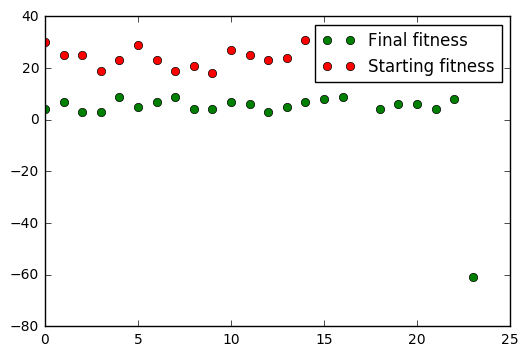

In [272]:
fit = 1000
count = 0
countMax = 40
results = []
best = (1000,0,0)
while fit > 0 and count < countMax:
    curr = runSteepestDescent()
    if curr[0] < best[0]:
        best = curr
    fit = curr[0]
    startingFitness = curr[3]
    results.append([count,fit,startingFitness])
    count += 1
# unpack curr to get at all the pieces
(fit,sked,trSlotsRemaining,startingFit,s) = best
print(best[0]," iterations:",count)
o = np.array(results)
plt.plot(o[:,0],o[:,1],'go')
plt.plot(o[:,0],o[:,2],'ro')
plt.legend(['Final fitness','Starting fitness'])
plt.show()

## When you find a good one, save a schedule to a file, to read back in later

In [276]:
s.saveSchedule(sked,trSlotsRemaining,'best.pickle')

## Read back in a schedule

In [277]:
(s,sked,trSlotsRemaining) = Scheduler.loadSchedule('best.pickle')

In [285]:
print(fitness(s,sked),fitness2(s,sked),fitnessOverall(s,sked))

0 38 -61


## Save the schedule to .ics iCalendar files

In [51]:
s.createCalendarFiles(sked)

# Simulated Annealing or Genetic Agorithm Solution or ??

In [ ]:
# yay!